# Clustering Example

This example notebook applies *k*-means clustering to the CHI data from the [HCI Bibliography](http://hcibib.org), building on the [Week 13 Example](https://cs533.ekstrandom.net/content/week13/Week13/).

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [3]:
rng = np.random.RandomState(20201119)

## Load Data

In [4]:
papers = pd.read_csv('chi-papers.csv', encoding='utf8')
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        13333 non-null  object
 1   title     13416 non-null  object
 2   authors   13416 non-null  object
 3   date      13422 non-null  object
 4   abstract  12926 non-null  object
 5   file      13422 non-null  object
 6   year      13422 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 734.1+ KB


Let's treat empty abstracts as empty strings:

In [5]:
papers['abstract'].fillna('', inplace=True)
papers['title'].fillna('', inplace=True)

For some purposes, we want *all text*.  Let's make a field:

In [6]:
papers['all_text'] = papers['title'] + ' ' + papers['abstract']

## Raw Clustering

Let's set up a *k*-means to make 10 clusters out of our titles and abstracts.  We're going to also limit the term vectors to only the 10K most common words, to make the vectors more manageable.

In [7]:
cluster_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('cluster', KMeans(5, random_state=rng))
])

In [8]:
cluster_pipe.fit(papers['all_text'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('cluster',
                 KMeans(n_clusters=5,
                        random_state=RandomState(MT19937) at 0x1F79F3B4B40))])

Now, if we want clusters for all of our papers, we use `predict`:

In [9]:
paper_clusters = cluster_pipe.predict(papers['all_text'])

C:\Users\benjaminpeterson\Anaconda3\envs\cs533-bib\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

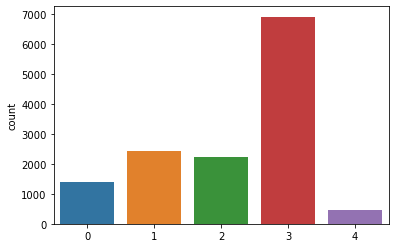

In [10]:
sns.countplot(paper_clusters)

We can, for instance, get the titles of papers in cluster 0:

In [11]:
papers.loc[paper_clusters == 0, 'title']

15       Interactive Textbook and Interactive Venn Diag...
18       Bringing Order to the Web: Automatically Categ...
27       An Observational Study of How Objects Support ...
28       Tagged Handles: Merging Discrete and Continuou...
29       Traversable Interfaces Between Real and Virtua...
                               ...                        
13368    Bringing sketching tools to keychain computers...
13383    A visual language for a sketch-based UI protot...
13386    Novice heuristic evaluations of a complex inte...
13408    SIG on one size fits all?: cultural diversity ...
13418    Use cases in task modeling and user interface ...
Name: title, Length: 1399, dtype: object

This created a Boolean mask that is `True` where the cluster number is equal to 0, and selects those rows and the `'title'` column.

Don't know if these papers make any sense, but they are clusters.  We aren't doing anything to find the *most* central papers to the cluster, though.

We can get that with `transform`, which will transform papers into *cluster distance space* - columns are the distances between each paper and that cluster:

In [12]:
paper_cdist = cluster_pipe.transform(papers['all_text'])

And we can find the papers *closest to the center* of cluster 0:

In [13]:
closest = np.argsort(paper_cdist[:, 0])[-10:]
papers.iloc[closest]['title']

1520                   Olympic voting system proposal
1509         2004 Athens 'Diskos': Olympic voting kit
10849      The Ergonomics Psychology Protect at INRIA
1450        Ambient urban interludes: passing glances
1498                                eLearning and fun
1521                PHOTOVOTE: Olympic judging system
11518                     Doctoral Consortium Faculty
1522                                        Shake it!
1460                              Emotion in a ticket
11105    Anthropomorphism: From Eliza to Terminator 2
Name: title, dtype: object

We can also look at clusters in space.  *t*-SNE is a technique for dimensionality reduction that is emphasized on visualizability.  Let's compute the *t*-SNE of our papers:

In [ ]:
sne_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', max_features=10000)),
    ('sne', TSNE())
])
paper_sne = sne_pipe.fit_transform(papers['all_text'])
paper_sne

Now we can plot:

In [ ]:
paper_viz = pd.DataFrame({
    'SNE0': paper_sne[:, 0],
    'SNE1': paper_sne[:, 1],
    'cluster': paper_clusters
})
sns.scatterplot('SNE0', 'SNE1', hue='cluster', style='cluster', data=paper_viz)

## SVD-based Clusters

Let's cluster in reduced-dimensional space:

In [ ]:
svd_cluster_pipe = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english')),
    ('svd', TruncatedSVD(10)),
    ('cluster', KMeans(10))
])
paper_svd_clusters = svd_cluster_pipe.fit_predict(papers['all_text'])

In [ ]:
sns.countplot(paper_svd_clusters)

In [ ]:
paper_svd_cdist = svd_cluster_pipe.transform(papers['all_text'])

Let's look at Cluster 0 in this space:

In [ ]:
closest = np.argsort(paper_svd_cdist[:, 0])[-10:]
papers.iloc[closest]['title']

Not sure if that's better, but it shows the concept.

Let's do the color-coded SNE visualization:

In [ ]:
paper_viz = pd.DataFrame({
    'SNE0': paper_sne[:, 0],
    'SNE1': paper_sne[:, 1],
    'cluster': paper_svd_clusters
})
sns.scatterplot('SNE0', 'SNE1', hue='cluster', data=paper_viz)